In [1]:
import pandas as pd
ANNOTATORS = ["A001", "A002", "A003", "A004", "A005", "A007", "A008", "A009", "A010", "A012"]
ANNOTATIONS = ["0-Kein", "1-Gering", "2-Vorhanden", "3-Stark", "4-Extrem"]

LABEL_VALS_QUAL={"0-Kein": 0, "1-Gering": 1, "2-Vorhanden": 1, "3-Stark": 1, "4-Extrem": 1}
LABEL_VALS_QUANT={"0-Kein": 0, "1-Gering": 1, "2-Vorhanden": 2, "3-Stark": 3, "4-Extrem": 4}

SEED = 42

In [2]:
import os

#creates all needed directories (doesn't clears them if they already exist), clears model-cache so grid-search will retrain models

if not os.path.isdir('created_data/training_data'):
    os.makedirs('created_data/training_data')
if not os.path.isdir('created_data/preprocessing_data_cache'):
    os.makedirs('created_data/preprocessing_data_cache')
if not os.path.isdir('created_data/embeddings'):
    os.makedirs('created_data/embeddings')
if not os.path.isdir('created_data/results'):
    os.makedirs('created_data/results')
if not os.path.isdir('models'):
    os.makedirs('models')   
with open("created_data/cache.txt", "w") as f:
    f.write("")
f.close()

In [3]:
dev_train = pd.read_json(path_or_buf="task_data/germeval-competition-traindev.jsonl", lines=True)
dev_test = pd.read_json(path_or_buf="task_data/germeval-competition-test.jsonl", lines=True)

dev_test.to_json("created_data/training_data/X_test.jsonl", orient='records', lines=True)

dev_train = dev_train.set_index('id')
dev_test = dev_test.set_index('id')

dev_train.to_pickle("created_data/preprocessing_data_cache/dev_train_after_import.pkl")
dev_test.to_pickle("created_data/preprocessing_data_cache/dev_test_after_import.pkl")


## Annotation Cols

Die Label Listen werden nach dem Annotator aufgeteilt sodass zu jedem Text 11 Annotator Labels (ggf. NaN) vorliegen. 

In [4]:
dev_train = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_after_import.pkl")
dev_test = pd.read_pickle("created_data/preprocessing_data_cache/dev_test_after_import.pkl")

#create a new dataframe with one column per annotator (plus text column)
dev_train_annotation_cols = pd.DataFrame(dev_train["text"], columns=["text", "avg"]+ANNOTATORS)

for idx, row in dev_train.iterrows():
    #loop over list in annotation field
    for dataset in row["annotations"]:
        #split list into entries for the annotator columns
        dev_train_annotation_cols[dataset['user']][idx] = dataset['label']
        
dev_train_annotation_cols.to_pickle("created_data/preprocessing_data_cache/dev_train_annotation_cols.pkl")

dev_train_X = pd.DataFrame(dev_train_annotation_cols["text"])
dev_train_X.to_pickle("created_data/preprocessing_data_cache/dev_train_X.pkl")

dev_train_y_all = pd.DataFrame(dev_train_annotation_cols[ANNOTATORS])

dev_train_y_all.to_pickle("created_data/preprocessing_data_cache/dev_train_y_All.pkl")

#save labels for each annotator separately
for annotator in ANNOTATORS:
    dev_train_y_a = pd.DataFrame(dev_train_annotation_cols[annotator][dev_train_annotation_cols[annotator].notnull()])
    dev_train_y_a.to_pickle(f"created_data/preprocessing_data_cache/dev_train_y_{annotator}.pkl")
dev_train_y_all

,A001,A002,A003,A004,A005,A007,A008,A009,A010,A012
id,,,,,,,,,,
a733e8a47708ce1d77060266d365e5b5,0-Kein,0-Kein,0-Kein,0-Kein,0-Kein,0-Kein,0-Kein,0-Kein,0-Kein,0-Kein
bf45fc2ac6742a7f75d5863c3338d59d,0-Kein,0-Kein,1-Gering,0-Kein,0-Kein,1-Gering,1-Gering,0-Kein,0-Kein,1-Gering
e1e80ff680f874d49ddfe33ac846a454,0-Kein,3-Stark,3-Stark,3-Stark,3-Stark,2-Vorhanden,4-Extrem,4-Extrem,4-Extrem,3-Stark
4689b9ccb5d79f222ba110f389cf1fb6,0-Kein,3-Stark,3-Stark,3-Stark,3-Stark,3-Stark,1-Gering,2-Vorhanden,0-Kein,3-Stark
a8d04dfc8e63b67f4587b04524605e3e,4-Extrem,4-Extrem,4-Extrem,4-Extrem,3-Stark,4-Extrem,2-Vorhanden,3-Stark,4-Extrem,2-Vorhanden
...,...,...,...,...,...,...,...,...,...,...
9bf20114b938ebe586073a61e1ed180c,NaN,2-Vorhanden,NaN,NaN,NaN,NaN,NaN,3-Stark,3-Stark,0-Kein
30b633296d7652efa94efeca713609d7,NaN,0-Kein,NaN,NaN,NaN,NaN,NaN,0-Kein,0-Kein,0-Kein
0917bc805a3b4c3086ee7101f2740dad,NaN,0-Kein,NaN,NaN,NaN,NaN,NaN,0-Kein,0-Kein,0-Kein


## Annotations Zählen
Für alle Annotatoren werden ihre Annotations gruppiert nach Klasse gezählt und gespeichert.

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import math

dev_train_annotation_cols = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_annotation_cols.pkl")

annotation_count = pd.DataFrame(index=["gesamt"]+ANNOTATORS, columns=ANNOTATIONS)

# count number of entries for each annotator
for annotator in ANNOTATORS:
    annotation_count.loc[annotator] = dev_train_annotation_cols[annotator].value_counts()
annotation_count.loc["gesamt"] = annotation_count.sum(axis='rows')

annotation_count.to_pickle("created_data/preprocessing_data_cache/dev_train_annotation_count.pkl")

## Label Piecharts

für jeden Annotator wird ein Piechart erstellt, welches die Verteilung seiner Annotations zeigt.

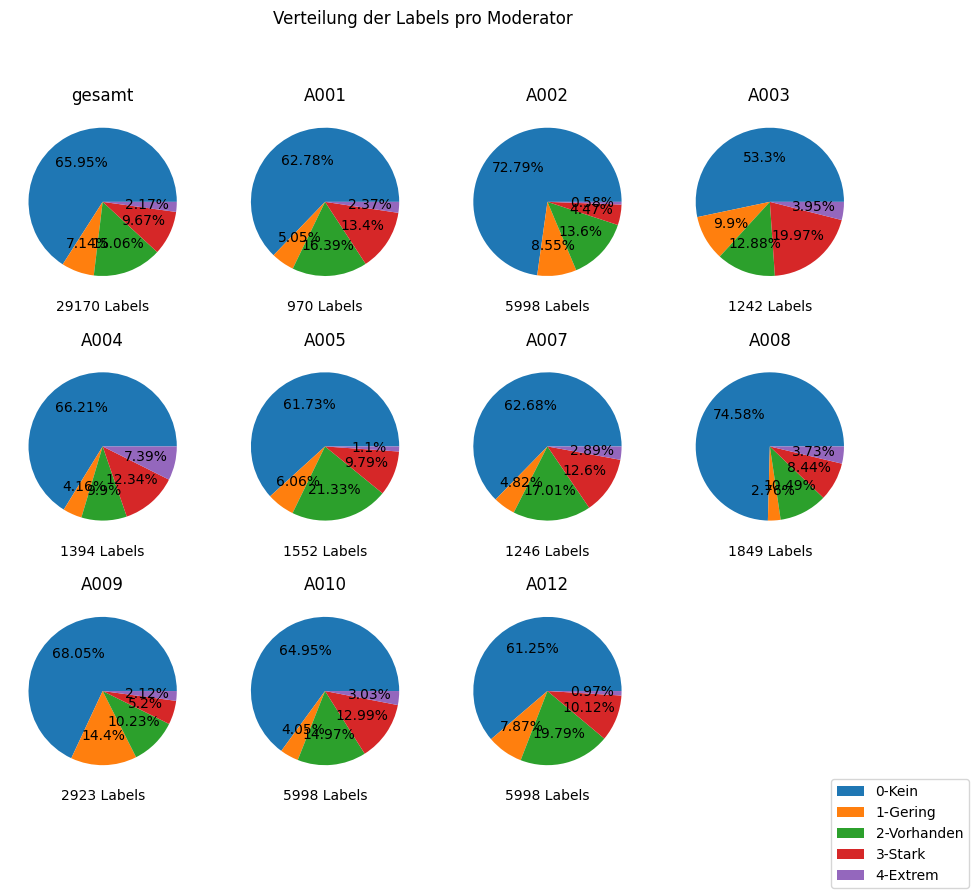

,0-Kein,1-Gering,2-Vorhanden,3-Stark,4-Extrem
gesamt,19237,2084,4394,2821,634
A001,609,49,159,130,23
A002,4366,513,816,268,35
A003,662,123,160,248,49
A004,923,58,138,172,103
A005,958,94,331,152,17
A007,781,60,212,157,36
A008,1379,51,194,156,69
A009,1989,421,299,152,62
A010,3896,243,898,779,182


In [6]:
annotation_count = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_annotation_count.pkl")

fig, axs = plt.subplots(3,4)
ax_idx = 0
for annotator in annotation_count.index:
    #callculate next ax
    ax = axs[math.floor(ax_idx / 4)][ax_idx % 4]
    
    #plot pie chart of row on next ax
    annotation_count.loc[annotator].plot.pie(ax=ax, figsize=(11,9), autopct= lambda pct: f"{round(pct, 2)}%", labels=None, title=annotator)
    annotator_label_count = annotation_count.loc[annotator][annotation_count.loc[annotator].notnull()].values.sum()
    ax.set(xlabel=f"{annotator_label_count} Labels", ylabel="")
    
    ax_idx += 1
fig.delaxes(axs[2][3])    
fig.suptitle("Verteilung der Labels pro Moderator")
fig.legend(annotation_count.columns, loc="lower right")
plt.show()
annotation_count

[]

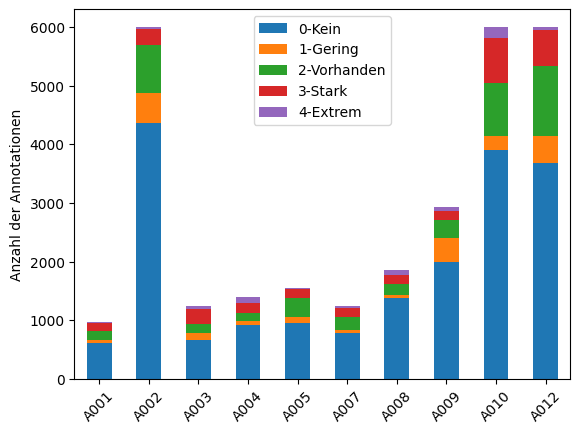

In [7]:
annotation_count.drop('gesamt').plot.bar(stacked=True)
plt.ylabel("Anzahl der Annotationen")
plt.xticks(rotation=45)
plt.plot()

## Label Anzahl Statistik
Es wird erfasst, wie vielen Datenpunkt wie viele unterschiedliche Labels zugeordnet sind. Bsp.: 

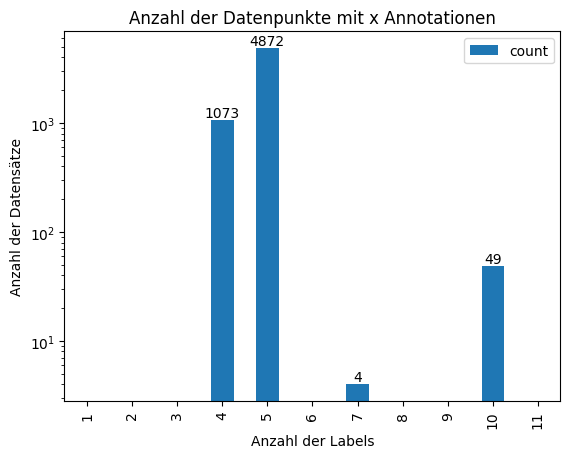

In [8]:
dev_train_y_all = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_All.pkl")
#count number of entries for each row
row_label_count = dev_train_y_all.count(axis='columns')

#count occurrence of entry-numbers (e.g. how many rows have 5 entries)  
occurrence_count = pd.DataFrame(row_label_count.value_counts(sort=False), index=range(1, 12)).fillna(0)

fig, ax = plt.subplots()
bars = occurrence_count.plot.bar(ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Anzahl der Labels")
ax.set_ylabel("Anzahl der Datensätze")
ax.bar_label(ax.containers[0])
ax.set_title("Anzahl der Datenpunkte mit x Annotationen")
plt.show()

## Mean / Majority Calculation

In [9]:
dev_train_y_all = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_All.pkl")

dev_train_y_all_quant = dev_train_y_all.applymap(lambda x: LABEL_VALS_QUANT[x] if not pd.isna(x) else x)
dev_train_y_all_qual = dev_train_y_all.applymap(lambda x: LABEL_VALS_QUAL[x] if not pd.isna(x) else x)

dev_train_y_all_quant.to_pickle("created_data/preprocessing_data_cache/dev_train_y_all_quant.pkl")
dev_train_y_all_qual.to_pickle("created_data/preprocessing_data_cache/dev_train_y_all_qual.pkl")

dev_train_y_mean_major = pd.DataFrame(index=dev_train_y_all.index, columns=["mean_quant", "mean_qual", "majority_val", "majority_label"])
dev_train_y_mean_major["mean_quant"] = dev_train_y_all_quant.mean(axis='columns')
dev_train_y_mean_major["mean_qual"] = dev_train_y_all_qual.mean(axis='columns')
dev_train_y_mean_major["majority_label"] = dev_train_y_all.mode(axis='columns')[0]
dev_train_y_mean_major["majority_val"] = dev_train_y_mean_major["majority_label"].apply(lambda x: LABEL_VALS_QUANT[x])

dev_train_y_mean_major.to_pickle("created_data/preprocessing_data_cache/dev_train_y_mean_major.pkl")
dev_train_y_mean_major

,mean_quant,mean_qual,majority_val,majority_label
id,,,,
a733e8a47708ce1d77060266d365e5b5,0.0,0.00,0,0-Kein
bf45fc2ac6742a7f75d5863c3338d59d,0.4,0.40,0,0-Kein
e1e80ff680f874d49ddfe33ac846a454,2.9,0.90,3,3-Stark
4689b9ccb5d79f222ba110f389cf1fb6,2.1,0.80,3,3-Stark
a8d04dfc8e63b67f4587b04524605e3e,3.4,1.00,4,4-Extrem
...,...,...,...,...
9bf20114b938ebe586073a61e1ed180c,2.0,0.75,3,3-Stark
30b633296d7652efa94efeca713609d7,0.0,0.00,0,0-Kein
0917bc805a3b4c3086ee7101f2740dad,0.0,0.00,0,0-Kein


## Annotator Bias

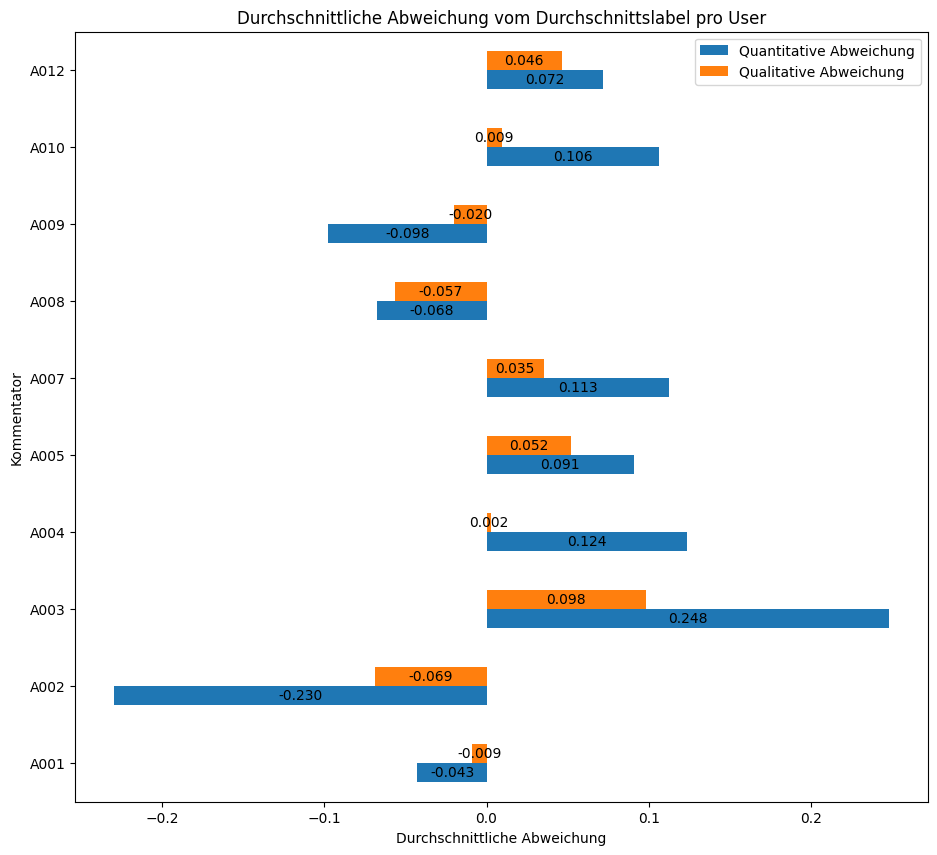

In [10]:
dev_train_y_all=pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_All.pkl")
dev_train_y_mean_major = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_mean_major.pkl")
dev_train_y_all_quant = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_all_quant.pkl")
dev_train_y_all_qual = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_all_qual.pkl")

dev_train_quant_diff = pd.DataFrame(index=dev_train_y_all.index, columns=ANNOTATORS)
dev_train_qual_diff = pd.DataFrame(index=dev_train_y_all.index, columns=ANNOTATORS)

for idx, mean_row in dev_train_y_mean_major.iterrows():
    quant_row = dev_train_y_all_quant.loc[idx]
    qual_row = dev_train_y_all_qual.loc[idx]
    not_null_mask = quant_row.notnull()
    
    dev_train_quant_diff.loc[idx] = quant_row[not_null_mask] - mean_row['mean_quant']
    dev_train_qual_diff.loc[idx] = qual_row[not_null_mask] - mean_row['mean_qual']

dev_train_bias = pd.DataFrame(index=["quant", "qual"], columns=ANNOTATORS)
dev_train_bias.loc["quant"] = dev_train_quant_diff.mean()
dev_train_bias.loc["qual"] = dev_train_qual_diff.mean()

ax = dev_train_bias.transpose().plot.barh(figsize=(11, 10))
ax.set_xlabel("Durchschnittliche Abweichung")
ax.set_ylabel("Kommentator")
ax.set_title("Durchschnittliche Abweichung vom Durchschnittslabel pro User")
ax.bar_label(ax.containers[0], fmt="%.3f", label_type="center")
ax.bar_label(ax.containers[1], fmt="%.3f", label_type="center")
ax.legend(["Quantitative Abweichung", "Qualitative Abweichung"])
plt.show()

## Correlation

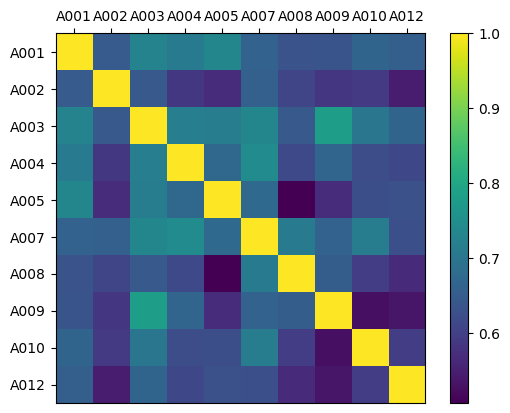

In [11]:
dev_train_y_all_quant: pd.DataFrame = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_all_quant.pkl")
dev_train_y_all_qual = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_all_qual.pkl")

correlation_quant = dev_train_y_all_quant.corr(method='kendall')
plt.imshow(correlation_quant, cmap='viridis')
plt.colorbar()
plt.xticks(range(0, 10), ANNOTATORS)
plt.yticks(range(0, 10), ANNOTATORS)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

## Train / Val Split

In [12]:
from sklearn.model_selection import train_test_split

#load Data
X_all = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_X.pkl")
y_all = pd.read_pickle("created_data/preprocessing_data_cache/dev_train_y_All.pkl")

#split y
y_train: pd.DataFrame
y_val: pd.DataFrame
y_train, y_val = train_test_split(y_all, train_size=0.8, test_size=0.2, random_state=SEED)

#correspondingly split X
X_train: pd.DataFrame = X_all.loc[y_train.index]
X_val: pd.DataFrame = X_all.loc[y_val.index]

y_train = y_train.applymap(lambda x: LABEL_VALS_QUANT[x] if not pd.isna(x) else x)
y_val = y_val.applymap(lambda x: LABEL_VALS_QUANT[x] if not pd.isna(x) else x)
y_all = y_all.applymap(lambda x: LABEL_VALS_QUANT[x] if not pd.isna(x) else x)

#add id to columns, so it will be written to the file too.
y_train["id"] = y_train.index
y_val["id"] = y_val.index
y_all["id"] = y_all.index
X_train["id"] = X_train.index
X_val["id"] = X_val.index
X_all["id"] = X_all.index




#write to jsonl files
y_train.to_json("created_data/training_data/y_train.jsonl", orient='records', lines=True)
y_val.to_json("created_data/training_data/y_val.jsonl", orient='records', lines=True)
y_all.to_json("created_data/training_data/y_all.jsonl", orient='records', lines=True)
X_train.to_json("created_data/training_data/X_train.jsonl", orient='records', lines=True)
X_val.to_json("created_data/training_data/X_val.jsonl", orient='records', lines=True)
X_all.to_json("created_data/training_data/X_all.jsonl", orient='records', lines=True)
#same steps for each annotato

for annotator in ANNOTATORS:
    y_train_anno_series = y_train[annotator].dropna()
    y_val_anno_series = y_val[annotator].dropna()
    
    y_train_anno = pd.DataFrame(y_train_anno_series, index=y_train_anno_series.index, columns=[annotator, 'id'])
    y_val_anno = pd.DataFrame(y_val_anno_series, index=y_val_anno_series.index, columns=[annotator, 'id'])
    
    X_train_anno = X_train.loc[y_train_anno.index]
    X_val_anno = X_val.loc[y_val_anno.index]
    
    y_train_anno['id'] = y_train_anno.index
    y_val_anno['id'] = y_val_anno.index

    y_train_anno.to_json(f"created_data/training_data/y_train_{annotator}.jsonl", orient='records', lines=True)
    y_val_anno.to_json(f"created_data/training_data/y_val_{annotator}.jsonl", orient='records', lines=True)
    X_train_anno.to_json(f"created_data/training_data/X_train_{annotator}.jsonl", orient='records', lines=True)
    X_val_anno.to_json(f"created_data/training_data/X_val_{annotator}.jsonl", orient='records', lines=True)
    
    print(f"{annotator}:\n  len(X_train): {len(X_train_anno)} \n  len(X_val): {len(X_val_anno)} \n")

A001:
  len(X_train): 786 
  len(X_val): 184 

A002:
  len(X_train): 4798 
  len(X_val): 1200 

A003:
  len(X_train): 986 
  len(X_val): 256 

A004:
  len(X_train): 1120 
  len(X_val): 274 

A005:
  len(X_train): 1252 
  len(X_val): 300 

A007:
  len(X_train): 988 
  len(X_val): 258 

A008:
  len(X_train): 1455 
  len(X_val): 394 

A009:
  len(X_train): 2344 
  len(X_val): 579 

A010:
  len(X_train): 4798 
  len(X_val): 1200 

A012:
  len(X_train): 4798 
  len(X_val): 1200 

